In [ ]:
m - в текст, yy - в строку

ORM DJANGO

Создание таблиц: 
для отображения в admin панели используем:
1. admin.site.register(Category) #просто как поле
2. @admin.register(Employer)  #в виде таблицы
    class EmployerAdmin(admin.ModelAdmin):
        list_display = ('user', 'boss_name', 'boss_count', 'changed_count')
        
Для миграции:
python manage.py makemigrations
python manage.py migrate

Для просмотра запросов SQL:

from django.db import connection
check = lambda : ([i.get("sql") for i in connection.queries][-1], len(connection.queries)) 


Пример создания таблиц бд:

In [ ]:
class Book(models.Model):
    title = models.CharField(
        max_length=200,
        verbose_name='Book name',
        help_text='Enter book name',
        null=True,
        blank=True
    )

    image_color = ColorField(format="hexa", null=True)
    created_date = models.DateTimeField(auto_now_add=True, editable=False)
    updated_date = models.DateTimeField(auto_now=True, editable=False)
    slug = models.SlugField(null=True, editable=False, blank=True)
    content = RichTextField(null=True, blank=True)
    category = models.ForeignKey('Category', on_delete=SET_NULL, null=True, blank=True)
    owner = models.ForeignKey(User, on_delete=models.CASCADE, null=True, related_name='books')
    author = models.ManyToManyField('Author', related_name='books', null=True, blank=True)

        def __str__(self):
        return self.title
    
class Author(models.Model):
    user = models.ForeignKey(User, on_delete=models.CASCADE, related_name='authors')
    name = models.CharField(max_length=200, verbose_name='Authors name')
    description = models.CharField(max_length=200, verbose_name='Authors description')

    def __str__(self):
        return self.name


class Category(models.Model):
    title = models.CharField(max_length=200, verbose_name='Category name')

    class Meta:
        verbose_name_plural = 'Categories'
        #abstract = True абстрактный класс, то есть бд проигнорит

    #class Meta(Book.Meta) - наследуемся от мета класса

    def __str__(self):
        return self.title
    
    
    class Employer(models.Model):
    user = models.OneToOneField(User, on_delete=models.CASCADE)
    boss=models.ManyToManyField('self', blank=True,  null=True, default=None, related_name='slaves',)

    changed_count = models.IntegerField(default=0, editable=False)

    # def save(self, *a, **kw):                           #способ увелеения с перегрузкой
    #     self.changed_count=self.slaves.count()
    #     return super(Employer, self).save(*a, **kw)

    @property
    def boss_count(self):
        return self.boss.count()

    @property
    def boss_name(self):
        return [self.boss.all()[i].user.username for i in range(self.boss.count())]

    def __str__(self):
        return self.user.username

    class Meta:
        verbose_name_plural = 'Employers'
        verbose_name = 'Employer'
        ordering=['-user']
        default_related_name = 'employer_set'

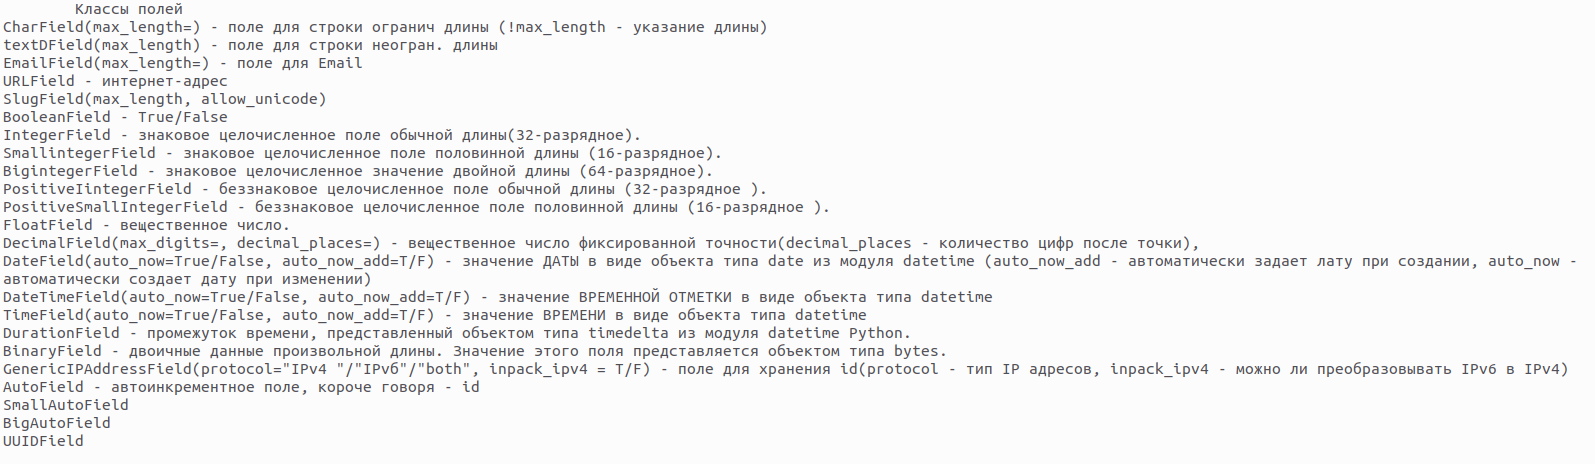

In [ ]:
CATEGORIES = [
        (DRUG_PRODUCTS, "Drug products"),
        (NUTRITIONAL_SUPPLEMENTS, "Nutritional supplements"),
        (MEDICAL_PRODUCTS, "Medical products"),
        (COSMETICS, "Cosmetics"),
        (OTHER_PRODUCTS, "Other products"),
        (HEALTHCARE_PRODUCTS, "Healthcare products"),
        (MEDICAL_DEVICES, "Medical devices"),
    ]

title = models.CharField(choices=CATEGORIES, max_length=30, primary_key=True) #choises - выбор из заранее занесенных в бд

In [2]:
#Связи:
    class Book(models.Model):
        category = models.ForeignKey('Category', on_delete=SET_NULL, related_name='book') #O2M
        author = models.ManyToManyField('Author', related_name='books')#M2M, нету арг. on_delete
        user = models.OneToOneField(User, on_delete=models.CASCADE, related_name='book')#O2O
        

#Аргументы полей(у каждого поля):
    #(технические)
    max_length = 50 #максимальная длина строки
    null=True/False # может ли поле быть пустым
    blank = True/False #может ли строка быть пустой
    primary_key = True/False #primary ключ, то есть поле становится полем, по которому идет соединение с другими таблицами (изначально id)
    default=... #значение по умолчанию
    unique=True/False #уникальное во всей таблице
    unique_for_date # поле, сохраняющее значение при условии, если уникальны в пределах даты:
        title = models.CharField(max_length=50,unique_for_date='published')
        published = models.DateTimeField()
    unique_for_month # что и _date, только с месяцем
    unique_for_year  # что и _date, только с годом
    db_index = True/False # индескирует полея, помогает искать объекты тем, что создает новую таблицу с полем необходимого вида (одинкаковое значение)
    
    
    
    #(для админ-панели)
    verbose_name='' #человеческое" название поля, которое будет выводиться на админке.
    help_text="" #дополнительный поясняющий текст, выводимый под полем ячейки в админке 
    editable = True/False # запрещает изменять значение поля в админ-панели
    
    #(для для таблицы)
    db_column="" #Имя столбца базы данных, используемого для этого поля.

#Аргументы частных случаев:
    #для DecimalField:
        max_digits=50 #максимальное количество цифр до запятой
        decimal_places=2 #количество цифр после запятой
    
    #для DateField, DateTimeField, TimeField
        auto_now=True/False #автоматически ставить запись при изменении/создании
        auto_now_add=True/False #автоматически ставить запись при создании
        
    #для GenericIPAddressField:
        protocol="IPv4 "/"IPvб"/"both" #какой протокол использовать
        inpack_ipv4 = T/F # можно ли преобразовывать IPv6 в IPv4
        
#Аргументы связей:
    #Общие:
        #Первый аргумент - поле, с которым идет связь (если модель описана выше, то без кавычек, в противном случае с ковычками), 'self' - поле указывает на свою таблицу
        related_name = "book" # имя атрибута записи первичной модели, предназначенного для доступа к связанным записям вторичной модели
        related_query_name='entry' #имя фильтра, которое будет применяться во вторичной модели для фильтрации по значениям из записи первичной модели
        db_constraint# если True, то в таблице базы данных будет создана связь, позволяющая сохранять ссылочную целостность
        to_field # имя поля первичной модели, по которому будет выполнена связь, в виде строки. Такое поле должно быть помечено как уникальное (если связано не через id)

        
    #O2O и O2M:
        on_delete: models.CASCADE #что будет при удалении записи из первичной таблицы (на которую ссылаемся)
                models.CASCADE # удаляет все связанные записи вторичной модели (каскадное удаление).
                        PROTECT # возбуждает исключение ProtectedError из модуля django.db.models, тем самым предотвращая удаление записи первичной модели.
                        SET_NULL # заносит в поле внешнего ключа всех связанных записей вторичной модели значение null. Сработает только в том случае, если поле внешнего ключа объявлено необязательным к заполнению на уровне базы данных (параметр null* конструктора поля имеет значение True).
                        SET_DEFAULT # заносит в поле внешнего ключа всех связанных записей вторичной модели заданное для него значение по умолчанию. Сработает только в том случае, если у поля внешнего ключа бьmо указано значение по умолчанию (оно задается параметром default конструктора поля).
                        SET(<значение>) # заносит в поле внешнего ключа указанное значение:
                            rubric = models.ForeingKey(Rubric, on_delete=models.SET(l))
                            или 
                            def get_first_rubric():
                                return Rubric.objects.first()
                            rubric = models.ForeingKey(Rubric, on_delete=models.SET(get_first_rubric)) # то есть вернет ссылку

                        DO_NOTНING # ничего не делает.
    
    
    #M2M
        limit_choices_to={'show': True} # как фильтрация, заданная списком параметров, выведет только соответствующие данные

    
    
    
#Мета-классы (для настройки всей таблицы):
        class Meta:
            verbose_name_plural = 'Employers' #как поле называется в множ. числе в админке
            verbose_name = 'Employer' #как поле называется в ед. числе в админке
            ordering=['-user', 'published'] # сортировка записей в определенном порядке (т.к. -user, то сортируется по user в обратном порядке)
            default_related_name = 'employer_set' #дефолтное значение related_name для всех полей
            unique_together=('title', 'published_date') #уникальность: не может быть создана запись с одинаковым именем и датойвместе
            get_latest_by=["published", "edited"] # определяет старшесть его записи в соответствии с заданными полями (потом исп при latest(), earliest())
            index_togeteher=[['published', 'title'], ['title', 'price', 'rubric']] # индексация вместе, то есть сразу создаются доп таблицы, рассортированные по группам
            db_name='' #название таблицы в БД
            abstract = True #поле становится абстрагированным
            

            
#полезные функции:
        def __str__(self): #получать норм название полей
        return self.user.username
    
        slug = models.SlugField(null=True, editable=False, blank=True)
        def save(self, *args, *kwargs): #при помощи save можно так же изменять поля, срабатывает во время сохранения записи
            #лучше использовать сигналы (далее)
            self.slug=slugify.slugify(f"{self.title}-{self.published_date}") #функция для слагирования
            return super().save(*args, **kwargs)
            
        

#@property: 
 @property #поле, которое не хранится в таблице и считается во время запроса, в запросах ее имя - название функции
    def boss_name(self):
        return [self.boss.all()[i].user.username for i in range(self.boss.count())]
    

        
        
    
            

IndentationError: unexpected indent (1039414747.py, line 2)

In [5]:
#ЗАПРОСЫ (для тестирования можно зайти в консоль python shell()):
    #Добавление записей:
        1. b1=prod(title='Дача', content='Some info', price = 5000)
        
        2.  b2 = prod()				#можно все записывать и в несколько строк
            b2.title = 'Автомобиль'
            b2.content = '"Жигули"'
            a.category = Categories.objects.filter(name=...)[0] 
            b2.save()
            
        3. prod=Product() #c использованием менеджера
           prod.objects.create(title='Дом', content='Трехэтажный, кирпич', price=50000000)
            
        (при добавлении связи нужно сначала создать запись, а потом добавлять)  
    #Обновление записей:
        a=Model.objects.get(title=...) #берем необходимое поле
        a.title = ...
        a.amount+=1
        a.category = Categories.objects.filter(name=...)[0] #присваивание O2M
        a.users.add(Users.objects.first()) #добавление в M2M записи
        a.save() #сохраняем поле
        a.pk # проверка на сохранность
        
        #F класс:
        product.price = F('price') * 1.2 # короч просто выполняет действия со всеми элементами указанного столбца 
        
    #Удаление модели
        a=Model.objects.get(title=...)
        a.delete()
        
        
        
    
    #Запросы значений из бд и использование менеджеров(objects - стандыртный менеджер, который используется при использовании объекта):
        #обычный запрос (когда a не QuerySet):
            a.title #то есть получаем значение
        
        #используем менеджер objects (помимо objects все функции можно применять к QuerySet, т.к. имеет функции менеджера)
            a=NameModel.objects #используем менеджер objects (чтобы )
            a=NameModel.objects.all() # получаем QuerySet (список с доп.возможностями) всех записей
            a=NameModel.objects.all()[i] #получить i-е значение 
            a=NameModel.objects.all()[a:b] #получить QuerySet из среза
            a=NameModel.objects.first()/last() #получить первую/последнбб запись
            a=NameModel.objects.latest()/earliest() #самую поседнюю/первую добавленную запись (в class Meta должен быть параметр "get_latest_by")
            a=NameModel.objects.all().values() #получить полный список всех полей всех записей

            a=NameModel.objects.get(name="") #выдергивает первую запись с этим значением, причем если такогого нет, вызывает ошибку
            a=NameModel.objects.filter(title='Дом') #возвращает QuerySet записей, у которых title="Дом"
        
        
        #запросы со связями:
        _____________________________________________________________________________________________________________
            class User(models.Model):
                name = models.CharField()
                
            class Writer(models.Model):
                user = models.OneToOneField(User, on_delete=models.CASCADE, related_name="writer")
                
                
            class Book(models.Model):
                title = models.CharField()
                writer = models.ForeignKey('Writer', related_name='book')
                reader = models.ManyToMany(User, related_name='books')
                amount=models.IntegerField()
       _______________________________________________________________________________________________________________
    
        a=User.objects.first()
        a.writer # получим объект Writer, который связан с User O2O, причем название поля, по которому получаем - related_name (изначально это название класса (Writer))
                 #Грубо говоря,  связь в обратную сторону по O2O настраивается автоматически
        a.books #Получим QuerySet из объекктов Book, название поля, по которому ищем = related_name (default = book_set)
        a.books.first().title #сразу получить название книги
        
        b=Writer.objects.first()
        b.user #получим объект User, который связан с объектом Writer через ForeignKey
        b.book #получим QuerySet из объектов Book (т.к. O2M от Book к Writer, то для Writer объекта будем QuerySet), название поля, по которому ищем = related_name (default = book_set)
          
        c=Book.objects.first()
        c.reader #получить QuerySet из объектов User (т.к. M2M)
        c.writer #получить объект Writer 
        
        В общем: объекты и QuerySet-ы можно получать с любой стороны связей между 2-мя таблицами, если получаем с другой
                 стороны связи, то поле будет иметь название, указанное в "related_name" поля, образующего соответсвующую 
                 связь.
                    
                    
        
        
        a=Book.objects.filter(writer.user.name='Vlad') #делаем фильтр со значением из хуй знает какого поля (получ QuerySet)
        a=Book.objects.filter(reader__name='Vlad') #так же для поиска, но исп "__", поскольку выбираем из QuerySet (так же можно сделать при О2М, О2О)
        a=Book.objects.filter(reader__name__contains='la') #будет искать записи, у которых в имени "la"
                                          __iconstains # без учета регистра
                                          __in # в диапазоне [] 	
                                          __gt # >
                                          __gte # >=
                                          __lt # <
                                          __lte # <=
                                          ...
        
        a=User.objects.filter(books__amount__gt=10) #Вернет Queryset авторов, у которых книги в количестве больше, чем 10
        
        В общем, штука нужна для удобного поиска
        

    #Запросы select_related, prefetch_related:
        User.ojects.select_related('Employer') # используется для получения объекта с данными другой таблицы при О2М
                                               # причем используя только один запрос (короч, это Join)
                                               # в качестве параметра передается название таблицы
        User.ojects.select_related('Employer').filter(username='adam_69')[0] #тут он еще и фильтрует!
        
        a = Cart.objects.prefetch_related('position') #что и select_related, но только для M2M
        
        
        
        
    #Составные запросы (Q класс) (и, или, отрицание):
        Employer.objects.filter(Q(boss__user__username__contains='ad') |/& Q(id_in=[1, 2, 3])) # или / и
        Employer.objects.filter(-Q(boss__user__username__contains='ad') #отрицание
                                
        #Можно делать матрешки: Employer.objects.filter(Q(Q()&Q())|-Q())
                                
                                
    
                                
                                

        
        
        
            
        
    
        
        

IndentationError: unindent does not match any outer indentation level (<tokenize>, line 62)